# CS 6140 Machine Learning: Assignment - 3 (Total Points: 100)
## Prof. Ahmad Uzair 

# Q1. Implement Support Vector Machines (SVMs) from scratch (35 Points)

## 1. Generate and visualize data: 
Run the following code to generate non-linearly separable data. 

In [125]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize

In [126]:
def gen_data():
    np.random.seed(105)
    Positive = np.concatenate((np.random.randn(10, 2) * 0.4 + [1.5, -0.5],
                             np.random.randn(10, 2) * 0.4 + [-1.5, 0.5]))
    Negative = np.random.randn(20, 2) * 0.3 + [0.0, -0.9]

    return Positive, Negative

## 2. Plot data
Perform data visualization on the above generated data. 


In [127]:
def plot_data(Positive, Negative):
    """
    Plots a 2-D scatterplot with Positive and Negative labels.
    :param Positive: feature values with positive label
    :param Negative: feature values with negative label
    """
    plt.scatter(Positive.T[0], Positive.T[1], color='blue')
    plt.scatter(Negative.T[0], Negative.T[1], color='red')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend(['Positive', 'Negative'])
    plt.show()

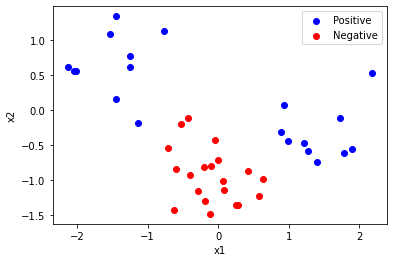

In [128]:
#Checking gen_data and plot_data
Positive, Negative = gen_data()
plot_data(Positive, Negative)

Expected output for visualization

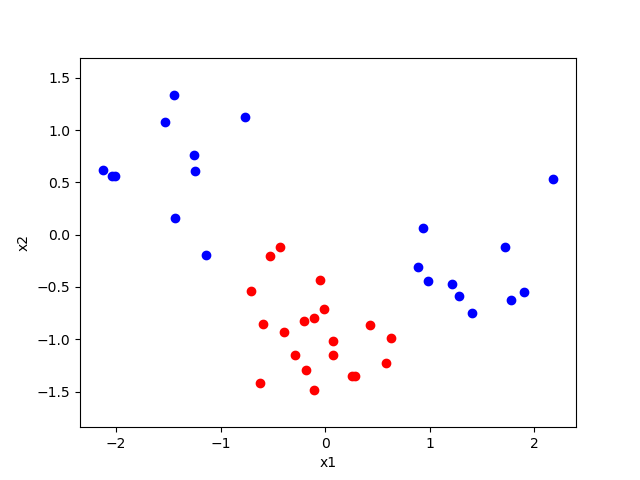

## 3. Fit SVM with linear kernel with slack variable (10+5 Points)
  - Implement **SVM with linear kernel**. Explain why training the linear kernel model without C would fail?  **(10 Points)**
Hint : You can use [minimize()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) of scipy.optimize for optimization of the dual function.  
  $max_\lambda q(λ) = \sum_i \lambda_i - \frac{1}{2}\sum_{ij} y_i y_j \lambda_i \lambda_jk(x_i, x_j)$

  You may need to modify the formulation to convert objective from maximization to minimization.
  $min_\lambda q(λ) = \frac{1}{2}\sum_{ij} y_i y_j \lambda_i \lambda_jk(x_i, x_j) - \sum_i \lambda_i$

  The minimize() function returns a dictionary that contains the optimal values of $\lambda$s stored in 'x' key. 
  - **Optimize slack variable**:  Fit linear kernel using C in [0,1,2,3,4,5]. Explain the effect of different choices of C.  **(5 Points)**


### Explain why training the linear kernel model without C would fail?
Given the distribution of the data, it can be seen that the data is linearly inseperable data using a linear hyperplane. Assuming no C, thus not having constraint on upper limit of lambdas would not work for this case.

In [129]:
def linear_kernel(x, y, kwargs):
    # insert your code here 
    # return linear kernel output
    return np.dot(x,y)

In [130]:
def fit(X, Y, C=None, kernel=None, kwargs = {}):
    '''
    X: input_data (Nx2) numpy array
    Y: binary target variable (N,) numpy array
    C: The slack variable
    kernel: kernel function (linear or polynomial)
    kwargs: dictionary of arguments
    '''
    # insert your code here
    # Apply optimization of dual function (Equation 7.10: Bishop)
    # make use of minimize()
    n = X.shape[0]
    
    def neg_dual(lamb):
        '''
        Returns the negative dual required for minimization.
        '''
        comp_sum = 0.0
        for i in range(n) :
            for j in range(n) :
                comp_sum+=Y[i]*Y[j]*lamb[i]*lamb[j]*kernel(X[i],X[j], kwargs)
        ans = np.sum(lamb) - (1/2)*comp_sum
        return -1*ans
        
    def lamb_y_constraint(lamb) :
        '''
        Constraint function on sum lamb*y = 0
        '''
        sum = 0.0
        for i in range(n):
            sum+=lamb[i]*Y[i]
        return sum
    
    def lamb_smaller_than_constraint(lamb):
        '''
        Constraint function on lamb <= C
        '''
        return C*np.ones(n) - lamb
    
    def lamb_greater_than_constraint(lamb):
        '''
        Constraint function on lamb >= 0
        '''
        return lamb
    
    
    if C is not None:
        constraints = ({'type': 'eq',   'fun': lamb_y_constraint},
                       {'type': 'ineq', 'fun': lamb_smaller_than_constraint},
                       {'type': 'ineq', 'fun': lamb_greater_than_constraint})
    else:
        constraints = ({'type': 'eq',   'fun': lamb_y_constraint},
               {'type': 'ineq', 'fun': lamb_greater_than_constraint})
    
    #Using optimize.minimize to minimize negative_dual which maximizes dual
    optRes = optimize.minimize(fun=neg_dual,
                           x0=np.ones(n),
                           constraints=constraints)
    
    #Lambdas stored in 'x' key
    return optRes.x

## 4. Linear Kernel decision boundary visualizaiton (10 Points)
Visualize datapoints and SVM decision boundary and margins with C=5. Color misclassified points appropriately. 
- Implement get_support_vectors() method that return support vectors based on 
- This would require you to implement a predict() method. (Slide 3 or Equation 7.13 : Bishop)




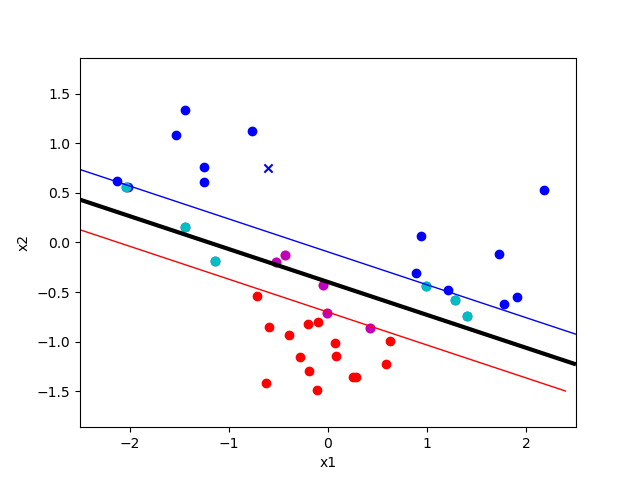

In [131]:
def get_support_vectors(X, Y, lambdas, threshold=10e-5):
    # insert your code here
    # return support vectors, target variable values of the support vectors, lambdas of support vectoss
    # remeber only lambdas >=0 are to be kept

    #X_support, Y_support and lambda_support to get support vectors having lambdas >threshold
    X_support = X[lambdas>threshold]
    Y_support = Y[lambdas>threshold]
    lambda_support = lambdas[lambdas>threshold]
    return X_support, Y_support, lambda_support

In [132]:
def get_intercept(s_vecs, s_vecs_Y, s_vecs_lambda, C,kernel, kwargs):
    '''
        Returns the intercept based on support vectors.
    '''
    num = s_vecs.shape[0]
    if num == 0:
        return 0
    if C == None:
        #Bishop equation 7.18 for non overlapping class
        b = 0.0
        for n in range(num):
            curr_sum = 0.0
            for m in range(num):
                curr_sum+=(s_vecs_lambda[m]*s_vecs_Y[m]*kernel(s_vecs[n], s_vecs[m], kwargs))
            b = b + (s_vecs_Y[n] - curr_sum)
        b = b/num
        return b
    else:
        #Bishop equation 7.37 for overlapping class
        num = s_vecs.shape[0]
        b = 0.0
        tot = 0
        for n in range(num):
            if s_vecs_lambda[n] < C-10e-5:
                tot+=1
                curr_sum = 0.0
                for m in range(num):
                    curr_sum+=(s_vecs_lambda[m]*s_vecs_Y[m]*kernel(s_vecs[n], s_vecs[m], kwargs))
                b = b + (s_vecs_Y[n] - curr_sum)
        b = b/tot
        return b

In [133]:
def getDistance(test_point, s_vecs, s_vecs_Y, s_vecs_lambda, kernel, intercept, kwargs):
    '''
    Gives the geometric distance from the decision boundary from support vectors.
    '''
    n = s_vecs.shape[0]
    val = 0.0
    for i in range(n):
        val += s_vecs_lambda[i] * s_vecs_Y[i] * kernel(s_vecs[i], test_point, kwargs)
    return val+intercept

def predict(test_point, s_vecs, s_vecs_Y, s_vecs_lambda, kernel, intercept, kwargs):
    '''
    test_point: test datapoint
    s_vecs: Support vectors 
    s_vecs_Y: target values of the Support vectors
    s_vec_lambda: Dual variables corresponding to the support vectors
    kernel, kwargs: kernel function (linear or polynomial)
    '''
    # insert your code here
    # Apply support vectors to predict the class of test_point (Equation 7.13: Bishop)
    val = getDistance(test_point, s_vecs, s_vecs_Y, s_vecs_lambda, kernel, intercept, kwargs=kwargs)
    if val>0:
        prediction = 1
    else:
        prediction = -1
    return prediction

In [134]:
def plot_decision_boundary(Positive, Negative,
                           ip_new,
                           s_vecs, s_vecs_Y, s_vec_lambda,
                           kernel, intercept, kwargs):
    '''
    Positive, Negative: Example datapoints from both classes
    test_point: test data point (2, )
    s_vecs: Support vectors
    s_vecs_Y: Target variable values for the support vectors
    s_vec_lambda: Dual variables corresponding to the support vectors
    kernel, kwargs: kernel function (linear or polynomial)
    '''
    # make use of plt.contour() and plt.scatter()
    # plot decision boundary along with margins
    
    fig, ax = plt.subplots()
    
    #Plotting the Positive and Negative labeled values
    ax.scatter(Positive.T[0], Positive.T[1], color='blue')
    ax.scatter(Negative.T[0], Negative.T[1], color='red')
    
    
    #Plotting the Positive and Negative support vectors
    positive_sv = s_vecs[s_vecs_Y == 1]
    negative_sv = s_vecs[s_vecs_Y == -1]
    
    ax.scatter(positive_sv.T[0], positive_sv.T[1], color='cyan')
    ax.scatter(negative_sv.T[0], negative_sv.T[1], color='pink')
    
    #Predicting and plotting the ip_new value
    pred = predict(ip_new,
                         s_vecs,
                         s_vecs_Y,
                         s_vecs_lambda,
                         kernel=kernel,
                         intercept = intercept,
                         kwargs=kwargs)
    if pred == 1:
        color = 'blue'
    else:
        color = 'red'
    ax.scatter(ip_new[0],ip_new[1], color=color, marker = 'x')
    
    #Countour plot for decision boundary and margins
    delta = 0.1
    x = np.arange(-2.5, 2.5, delta)
    y = np.arange(-2.0, 2.0, delta)
    X, Y = np.meshgrid(x, y)
    Z = np.array([getDistance([X[i][j],Y[i][j]],s_vecs, s_vecs_Y, s_vecs_lambda, kernel, intercept, kwargs) for i in range(X.shape[0]) for j in range(X.shape[1])]).reshape(X.shape)
    CS = ax.contour(X, Y, Z, levels=[-1,0,1],colors=('red', 'black', 'blue'),linewidths=(1.5,3.0,1.5))
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()


The following function will be used to test your solution.

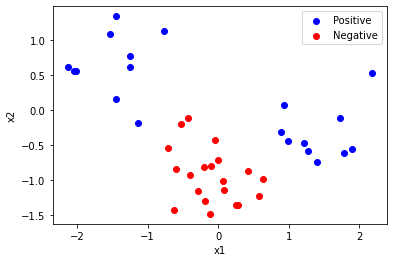

11 support vectors found.
 [[-2.03524537  0.56015045]
 [ 0.98524228 -0.44313042]
 [ 1.2778755  -0.58188648]
 [-1.44075191  0.15927811]
 [-0.00892175 -0.71463001]
 [-1.14212888 -0.19215842]
 [-0.04612834 -0.43374017]
 [ 0.42448628 -0.86445712]
 [-0.43042553 -0.1224234 ]
 [-0.52528106 -0.19958112]
 [ 1.40186973 -0.74534088]]
Input:[-0.6   0.75] predicted as 1.


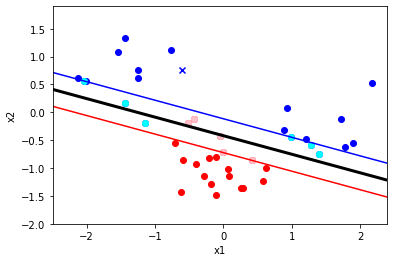

In [135]:
# Test code
if __name__ == '__main__':
    Positive, Negative = gen_data()
    plot_data(Positive, Negative)
    X = np.concatenate((Positive, Negative))
    Y = np.concatenate((np.ones(Positive.shape[0]), -np.ones(Negative.shape[0])))
    size = X.shape[0]
    shuffle_data = list(range(size))
    random.shuffle(shuffle_data)
    X = X[shuffle_data, :]
    Y = Y[shuffle_data]
    
    slack_variable = 5

    lambdas = fit(X,
                Y,
                C=slack_variable, # slack variable
                kernel=linear_kernel,
                kwargs={})
    # Get the alpha values for the support vectors, as well as their target data.
    s_vecs, s_vecs_Y, s_vecs_lambda = get_support_vectors(X,
                                                         Y,
                                                         lambdas)
    print(f"{s_vecs.shape[0]} support vectors found.\n", s_vecs)
    
    intercept = get_intercept(s_vecs, s_vecs_Y, s_vecs_lambda, C=slack_variable, kernel=linear_kernel, kwargs = {})
    
    # test new data point
    ip_new = np.array([-0.6, 0.75])
    prediction = predict(ip_new,
                         s_vecs,
                         s_vecs_Y,
                         s_vecs_lambda,
                         kernel=linear_kernel,
                         intercept = intercept,
                         kwargs={})
    print(f'Input:{ip_new} predicted as {prediction}.')

    plot_decision_boundary(  Positive, Negative,
                             ip_new,
                             s_vecs,
                             s_vecs_Y,
                             s_vecs_lambda,
                             kernel=linear_kernel,
                             intercept = intercept,
                             kwargs={})


### Optimize slack variable:
The slack variable determines the penalty upon misclassification of feature values. Thus increasing the slack variable will make stricter margins and thus reduce the number of support vectors. As C -> infinity, margin becomes hard.
And thus as expected, as we increase the C, the margins become harder of our support vector and number of support vectors decrease. C=0 is an invalid slack variable which would limit all the lambdas to 0 which would not create a hyperplane.

C=0.2, number of support vectors=27


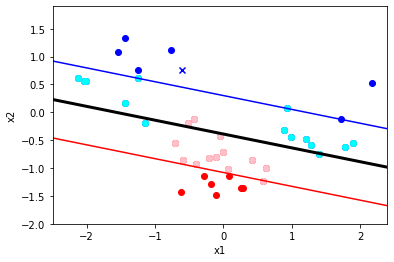

C=0.5, number of support vectors=21


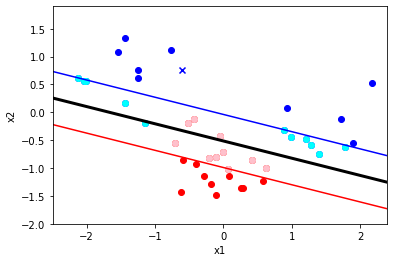

C=1, number of support vectors=17


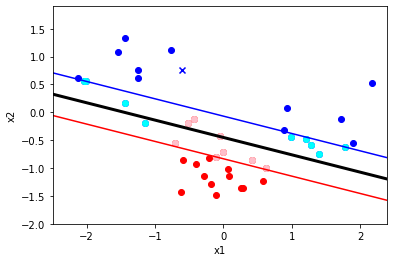

C=2, number of support vectors=12


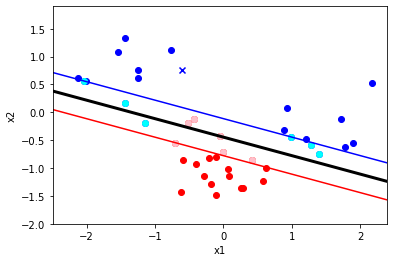

C=3, number of support vectors=12


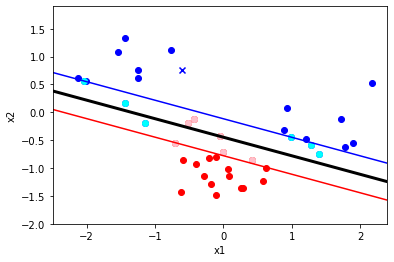

C=4, number of support vectors=11


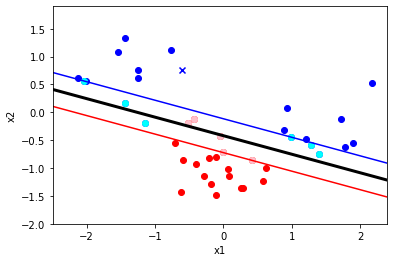

C=5, number of support vectors=11


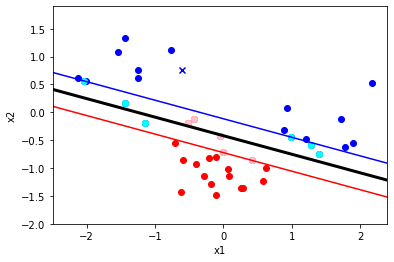

C=10, number of support vectors=9


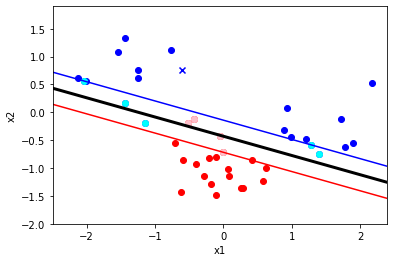

In [123]:
C = [0.2, 0.5,1,2,3,4,5,10]
support_vectors = []
for c in C:
    lambdas = fit(X,
            Y,
            C=c, # slack variable
            kernel=linear_kernel,
            kwargs={})
    s_vecs, s_vecs_Y, s_vecs_lambda = get_support_vectors(X,
                                                         Y,
                                                         lambdas)
    support_vectors.append(s_vecs.shape[0])
    
    intercept = get_intercept(s_vecs, s_vecs_Y, s_vecs_lambda, C=c,kernel=linear_kernel, kwargs={})
    print(f'C={c}, number of support vectors={s_vecs.shape[0]}')
    plot_decision_boundary(  Positive, Negative,
                             ip_new,
                             s_vecs,
                             s_vecs_Y,
                             s_vecs_lambda,
                             kernel=linear_kernel,
                             intercept = intercept,
                             kwargs={})

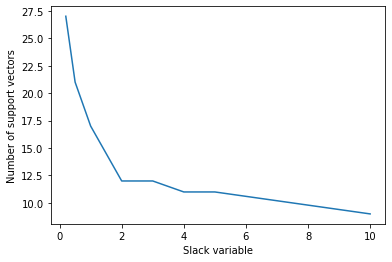

In [124]:
#Plotting the number of support vectors as slack variable increases
plt.plot(C, support_vectors)
plt.xlabel('Slack variable')
plt.ylabel('Number of support vectors')
plt.show()

## 5. SVM with polynomial kernel.  (10 Points)
Implement polynomial kernel function. Fit the same data with polynomial of degree 2.


In [136]:
def polynomial_kernel(x, y, kwargs):
    # insert your code here
    # return polynomial kernel output
    return (np.dot(x,y) +1)**(kwargs['p'])

The following functions are to be used to test your implementation.

5 support vectors found.
 [[ 0.88640301 -0.31171598]
 [-1.14212888 -0.19215842]
 [-0.52528106 -0.19958112]
 [-0.76590095  1.12063704]
 [ 0.62905985 -0.99111128]]
Input:[-0.6   0.75] predicted as 1.


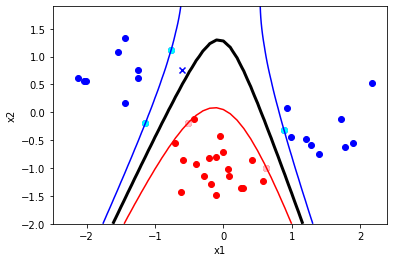

In [137]:
if __name__ == '__main__':
    Positive, Negative = gen_data()
    # plot_data(Positive, Negative)
    X = np.concatenate((Positive, Negative))
    Y = np.concatenate((np.ones(Positive.shape[0]), -np.ones(Negative.shape[0])))
    size = X.shape[0]
    shuffle_data = list(range(size))
    random.shuffle(shuffle_data)
    X = X[shuffle_data, :]
    Y = Y[shuffle_data]

    # test_linear(X, Y)
    kernel = polynomial_kernel
    kwargs = {'p': 2}
    slack_variable = None
    lambdas = fit(X,
                Y,
                C=slack_variable, # slack variable
                kernel=kernel,
                kwargs=kwargs)
    # Get the alpha values for the support vectors, as well as their target data.
    s_vecs, s_vecs_Y, s_vecs_lambda = get_support_vectors(X,
                                                         Y,
                                                         lambdas)
    print(f"{s_vecs.shape[0]} support vectors found.\n", s_vecs)
    
    intercept = get_intercept(s_vecs, s_vecs_Y, s_vecs_lambda, C=slack_variable, kernel=kernel, kwargs = kwargs)
    
    # test new data point
    ip_new = np.array([-0.6, 0.75])
    prediction                                                                                                                                                                                                                                                                                = predict(ip_new,
                         s_vecs,
                         s_vecs_Y,
                         s_vecs_lambda,
                         kernel=kernel,
                         intercept = intercept,
                         kwargs=kwargs)
    print(f'Input:{ip_new} predicted as {prediction}.')

    plot_decision_boundary(  Positive, Negative,
                             ip_new,
                             s_vecs,
                             s_vecs_Y,
                             s_vecs_lambda,
                             kernel=kernel,
                             intercept = intercept,
                             kwargs=kwargs)

Expected output.

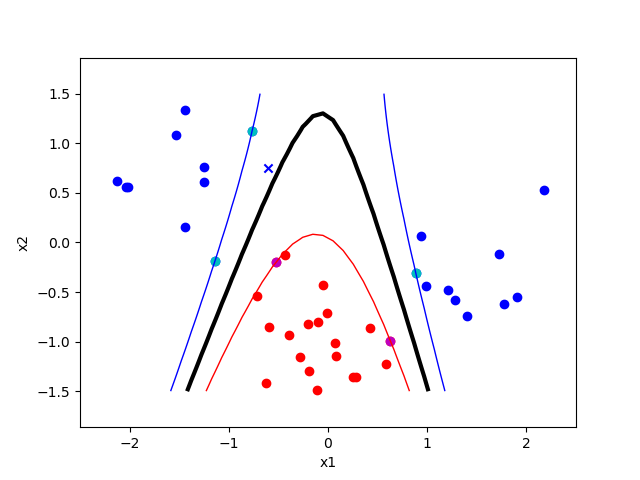

# Q2. Neural Networks (25 Points)

1. Forward Propagation : Find the value of L (7 points)
2. Backward Propagation: Find all the derivatives(of all xi,x2,y1,y2,z2,z2,z) wrt to each inputs and weights (18 points)

Consider the weights as shown below

![ANN.jpg](attachment:ANN.jpg)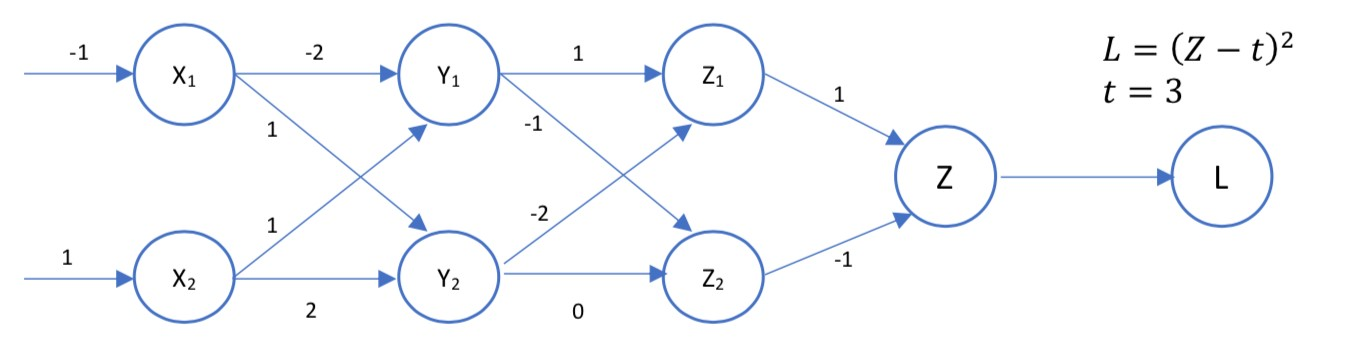

### 1. Forward Propagation:
Let us name the weights as $w_{destination,source}$ Then we have:
\begin{align}
    X_1 &= w_{X_1} \\
        &= -1 \\
    X_2 &= w_{X_2} \\
        &= 1 \\
    Y_1 &= w_{Y_1,X_1}X_1 + w_{Y_1,X_2}X_2 \\
        &= (-2)(-1) + (1)(1) \\
        &= 3 \\
    Y_2 &= w_{Y_2,X_1}X_1 + w_{Y_2,X_2}X_2 \\
        &= (1)(-1) + (2)(1) \\
        &= 1 \\
    Z_1 &= w_{Z_1,Y_1}Y_1 + w_{Z_1,Y_2}Y_2 \\
        &= (1)(3) + (-2)(1) \\
        &= 1 \\
    Z_2 &= w_{Z_2,Y_1}Y_1 + w_{Z_2,Y_2}Y_2 \\
        &= (-1)(3) + (0)(1) \\
        &= -3 \\
    Z &= w_{Z,Z_1}Z_1 + w_{Z,Z_2}Z_2 \\
        &= (1)(1) + (-1)(-3) \\
        &= 4 \\
    L &= (Z-t)^2 \\
        &= (4-3)^2 \\
        &= 1
\end{align}
Thus we get $L=1$.

### 2. Backward Propagation:
For back propagation, we require the following:
\begin{align}
    \frac{\partial L}{\partial Z} &= \frac{\partial (Z-t)^2}{\partial Z} = 2(Z-t) = 2 \\
    \frac{\partial Z}{\partial w_{Z,Z_1}} &= \frac{\partial (w_{Z,Z_1}Z_1 + w_{Z,Z_2}Z_2)}{\partial w_{Z,Z_1}} = Z_1 = 1\\
    \frac{\partial Z}{\partial w_{Z,Z_2}} &= \frac{\partial (w_{Z,Z_1}Z_1 + w_{Z,Z_2}Z_2)}{\partial w_{Z,Z_2}} = Z_2 = -3\\
    \frac{\partial Z_1}{\partial w_{Z_1,Y_1}} &= \frac{\partial (w_{Z_1,Y_1}Y_1 + w_{Z_1,Y_2}Y_2)}{\partial w_{Z_1,Y_1}} = Y_1 = 3\\
    \frac{\partial Z_1}{\partial w_{Z_1,Y_2}} &= \frac{\partial (w_{Z_1,Y_1}Y_1 + w_{Z_1,Y_2}Y_2)}{\partial w_{Z_1,Y_2}} = Y_2 = 1\\
    \frac{\partial Z_2}{\partial w_{Z_2,Y_1}} &= \frac{\partial (w_{Z_2,Y_1}Y_1 + w_{Z_2,Y_2}Y_2)}{\partial w_{Z_2,Y_1}} = Y_1 = 3\\
    \frac{\partial Z_2}{\partial w_{Z_2,Y_2}} &= \frac{\partial (w_{Z_2,Y_1}Y_1 + w_{Z_2,Y_2}Y_2)}{\partial w_{Z_2,Y_2}} = Y_2 = 1\\
    \frac{\partial Y_1}{\partial w_{Y_1,X_1}} &= \frac{\partial (w_{Y_1,X_1}X_1 + w_{Y_1,X_2}X_2)}{\partial w_{Y_1,X_1}} = X_1 = -1 \\
    \frac{\partial Y_1}{\partial w_{Y_1,X_2}} &= \frac{\partial (w_{Y_1,X_1}X_1 + w_{Y_1,X_2}X_2)}{\partial w_{Y_1,X_2}} = X_2 = 1 \\
    \frac{\partial Y_2}{\partial w_{Y_2,X_1}} &= \frac{\partial (w_{Y_2,X_1}X_1 + w_{Y_2,X_2}X_2)}{\partial w_{Y_2,X_1}} = X_1 = -1 \\
    \frac{\partial Y_2}{\partial w_{Y_2,X_2}} &= \frac{\partial (w_{Y_2,X_1}X_1 + w_{Y_2,X_2}X_2)}{\partial w_{Y_2,X_2}} = X_2 = 1 \\
    \frac{\partial X_1}{\partial w_{X_1}} &= \frac{\partial w_{X_1}}{\partial w_{X_1}} = 1 \\
    \frac{\partial X_2}{\partial w_{X_2}} &= \frac{\partial w_{X_2}}{\partial w_{X_2}} = 1 \\
    \frac{\partial Z}{\partial Z_1} &= \frac{\partial (w_{Z,Z_1}Z_1 + w_{Z,Z_2}Z_2)}{\partial Z_1} = w_{Z,Z_1} = 1 \\
    \frac{\partial Z}{\partial Z_2} &= \frac{\partial (w_{Z,Z_1}Z_1 + w_{Z,Z_2}Z_2)}{\partial Z_2} = w_{Z,Z_2} = -1 \\
    \frac{\partial Z_1}{\partial Y_1} &= \frac{\partial (w_{Z_1,Y_1}Y_1 + w_{Z_1,Y_2}Y_2)}{\partial Y_1} = w_{Z_1,Y_1} = 1\\
    \frac{\partial Z_1}{\partial Y_2} &= \frac{\partial (w_{Z_1,Y_1}Y_1 + w_{Z_1,Y_2}Y_2)}{\partial Y_2} = w_{Z_1,Y_2} = -2 \\
    \frac{\partial Z_2}{\partial Y_1} &= \frac{\partial (w_{Z_2,Y_1}Y_1 + w_{Z_2,Y_2}Y_2)}{\partial Y_1} = w_{Z_2,Y_1} = -1 \\
    \frac{\partial Z_2}{\partial Y_2} &= \frac{\partial (w_{Z_2,Y_1}Y_1 + w_{Z_2,Y_2}Y_2)}{\partial Y_2} = w_{Z_2,Y_2} = 0\\
    \frac{\partial Y_1}{\partial X_1} &= \frac{\partial (w_{Y_1,X_1}X_1 + w_{Y_1,X_2}X_2)}{\partial X_1} = w_{Y_1,X_1} = -2\\
    \frac{\partial Y_1}{\partial X_2} &= \frac{\partial (w_{Y_1,X_1}X_1 + w_{Y_1,X_2}X_2)}{\partial X_2} = w_{Y_1,X_2} = 1\\
    \frac{\partial Y_2}{\partial X_1} &= \frac{\partial (w_{Y_2,X_1}X_1 + w_{Y_2,X_2}X_2)}{\partial X_1} = w_{Y_2,X_1} = 1\\
    \frac{\partial Y_2}{\partial X_2} &= \frac{\partial (w_{Y_2,X_1}X_1 + w_{Y_2,X_2}X_2)}{\partial X_2} = w_{Y_2,X_2} = 2
\end{align}

# Q3.Understanding Random Forest Classifier (40 Points)

1. Build a Random Forest classifier for the [handwritten digits dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits/) and find its performance (classification report, confusion matrix) (3 Points)

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
digits = load_digits()

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        28
           1       0.97      1.00      0.99        38
           2       1.00      1.00      1.00        31
           3       0.98      0.95      0.96        43
           4       0.98      0.98      0.98        45
           5       0.95      0.93      0.94        40
           6       0.97      1.00      0.98        30
           7       0.93      1.00      0.96        27
           8       0.94      0.94      0.94        31
           9       0.96      0.94      0.95        47

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



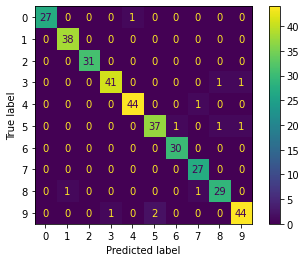

In [68]:
input_shape = np.shape(digits.images)
n_samples = input_shape[0]
n_features = input_shape[1] * input_shape[2]

X = digits.images.reshape((n_samples, n_features))
Y = digits.target

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

#Training the model
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)

#Predicting
Y_pred = clf.predict(X_test)

#Performance
print(classification_report(Y_test, Y_pred))
print(ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred))

2. Investigate following parameters of Random Forest classifier and tune them using Randomized Search and Grid Search. (15 points)
- Number of nodes per tree
- Number of trees
- Depth of trees
- Minimum Samples to split
- Minumum Samples in leaf

Use seed 1 and split the data into 80/20 train/val sets. Traing a classifier with each unique configuration and record train/val accuracy, precision and recall in the results dataframe. This dataframe will have 5 columns (each corresponding to tuning parameter) and each row will correspond to each unique configuration. 5x5x5x5x5 rows. 

Visualize the results dataframe using [parallel coordinates](https://pandas.pydata.org/docs/reference/api/pandas.plotting.parallel_coordinates.html). You will create a column in results dataframe that contains label of each row. Create labels according to accuracy score 50-60 (D), 60-70 (C), 70-80 (B), 80-90 (A), 90+ (A+). These labels will be required for parallel coordinates plot.

Analyze of the impace of each tuning parameter on predictor performance.


In [26]:
input_shape = np.shape(digits.images)
n_samples = input_shape[0]
n_features = input_shape[1] * input_shape[2]

X = digits.images.reshape((n_samples, n_features))
Y = digits.target

#Setting random seed and train/val split
random.seed(1)
shuffle_data = list(range(n_samples))
random.shuffle(shuffle_data)
X = X[shuffle_data, :]
Y = Y[shuffle_data]

X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.2)

In [27]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

# The paramater values are only suggestive. You can come up with better choices.

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = [2,4,8,16,64]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,5)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 8, 11, 14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8]


In [28]:
count = 0

#Arrays to store details of each estimator to be added in dataframe.
n_estimators_list = []
max_features_list = []
max_depth_list = []
min_samples_split_list = []
min_samples_leaf_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1_score_list = []
category_list = []

#Looping over all the parameters
for n in n_estimators:
    for features in max_features:
        for depth in max_depth:
            for samples_split in min_samples_split:
                for samples_leaf in min_samples_leaf:
                    count+=1
                    print("Training: "+str(count))
                    
                    #Training the model
                    clf = RandomForestClassifier(n_estimators=n,
                                                 max_features = features,
                                                 max_depth = depth,
                                                 min_samples_split = samples_split,
                                                 min_samples_leaf = samples_leaf)
                    clf.fit(X_train, Y_train)
                    
                    Y_pred = clf.predict(X_val)
                    classification_report_dict = classification_report(Y_val, Y_pred, output_dict=True)
                    
                    #Appending the details of the model in lists along with performances
                    n_estimators_list.append(n)
                    max_features_list.append(features)
                    max_depth_list.append(depth)
                    min_samples_split_list.append(features)
                    min_samples_leaf_list.append(samples_leaf)
                    accuracy = classification_report_dict['accuracy']
                    accuracy_list.append(classification_report_dict['accuracy'])
                    precision_list.append(classification_report_dict['weighted avg']['precision'])
                    recall_list.append(classification_report_dict['weighted avg']['recall'])
                    f1_score_list.append(classification_report_dict['weighted avg']['f1-score'])
                    
                    #Finding the category based on accuracy
                    category = 'D'
                    if accuracy < 0.7:
                        category = 'C'
                    elif accuracy < 0.8:
                        category = 'B'
                    elif accuracy < 0.9:
                        category = 'A'
                    else:
                        category = 'A+'
                    category_list.append(category)

# Creating dataframe from the lists of parameters and performances 
df = pd.DataFrame({
    'n_estimators':n_estimators_list,
    'max_features' : max_features_list,
    'max_depth' : max_depth_list,
    'min_samples_split' : min_samples_split_list,
    'min_samples_leaf' : min_samples_leaf_list,
    'accuracy' : accuracy_list,
    'precision' : precision_list,
    'recall' : recall_list,
    'f-1 score' : f1_score_list,
    'category' : category_list
})

Training: 1
Training: 2
Training: 3
Training: 4
Training: 5
Training: 6
Training: 7
Training: 8
Training: 9
Training: 10
Training: 11
Training: 12
Training: 13
Training: 14
Training: 15
Training: 16
Training: 17
Training: 18
Training: 19
Training: 20
Training: 21
Training: 22
Training: 23
Training: 24
Training: 25
Training: 26
Training: 27
Training: 28
Training: 29
Training: 30
Training: 31
Training: 32
Training: 33
Training: 34
Training: 35
Training: 36
Training: 37
Training: 38
Training: 39
Training: 40
Training: 41
Training: 42
Training: 43
Training: 44
Training: 45
Training: 46
Training: 47
Training: 48
Training: 49
Training: 50
Training: 51
Training: 52
Training: 53
Training: 54
Training: 55
Training: 56
Training: 57
Training: 58
Training: 59
Training: 60
Training: 61
Training: 62
Training: 63
Training: 64
Training: 65
Training: 66
Training: 67
Training: 68
Training: 69
Training: 70
Training: 71
Training: 72
Training: 73
Training: 74
Training: 75
Training: 76
Training: 77
Training

Training: 594
Training: 595
Training: 596
Training: 597
Training: 598
Training: 599
Training: 600
Training: 601
Training: 602
Training: 603
Training: 604
Training: 605
Training: 606
Training: 607
Training: 608
Training: 609
Training: 610
Training: 611
Training: 612
Training: 613
Training: 614
Training: 615
Training: 616
Training: 617
Training: 618
Training: 619
Training: 620
Training: 621
Training: 622
Training: 623
Training: 624
Training: 625
Training: 626
Training: 627
Training: 628
Training: 629
Training: 630
Training: 631
Training: 632
Training: 633
Training: 634
Training: 635
Training: 636
Training: 637
Training: 638
Training: 639
Training: 640
Training: 641
Training: 642
Training: 643
Training: 644
Training: 645
Training: 646
Training: 647
Training: 648
Training: 649
Training: 650
Training: 651
Training: 652
Training: 653
Training: 654
Training: 655
Training: 656
Training: 657
Training: 658
Training: 659
Training: 660
Training: 661
Training: 662
Training: 663
Training: 664
Traini

Training: 1168
Training: 1169
Training: 1170
Training: 1171
Training: 1172
Training: 1173
Training: 1174
Training: 1175
Training: 1176
Training: 1177
Training: 1178
Training: 1179
Training: 1180
Training: 1181
Training: 1182
Training: 1183
Training: 1184
Training: 1185
Training: 1186
Training: 1187
Training: 1188
Training: 1189
Training: 1190
Training: 1191
Training: 1192
Training: 1193
Training: 1194
Training: 1195
Training: 1196
Training: 1197
Training: 1198
Training: 1199
Training: 1200
Training: 1201
Training: 1202
Training: 1203
Training: 1204
Training: 1205
Training: 1206
Training: 1207
Training: 1208
Training: 1209
Training: 1210
Training: 1211
Training: 1212
Training: 1213
Training: 1214
Training: 1215
Training: 1216
Training: 1217
Training: 1218
Training: 1219
Training: 1220
Training: 1221
Training: 1222
Training: 1223
Training: 1224
Training: 1225
Training: 1226
Training: 1227
Training: 1228
Training: 1229
Training: 1230
Training: 1231
Training: 1232
Training: 1233
Training: 

Training: 1715
Training: 1716
Training: 1717
Training: 1718
Training: 1719
Training: 1720
Training: 1721
Training: 1722
Training: 1723
Training: 1724
Training: 1725
Training: 1726
Training: 1727
Training: 1728
Training: 1729
Training: 1730
Training: 1731
Training: 1732
Training: 1733
Training: 1734
Training: 1735
Training: 1736
Training: 1737
Training: 1738
Training: 1739
Training: 1740
Training: 1741
Training: 1742
Training: 1743
Training: 1744
Training: 1745
Training: 1746
Training: 1747
Training: 1748
Training: 1749
Training: 1750
Training: 1751
Training: 1752
Training: 1753
Training: 1754
Training: 1755
Training: 1756
Training: 1757
Training: 1758
Training: 1759
Training: 1760
Training: 1761
Training: 1762
Training: 1763
Training: 1764
Training: 1765
Training: 1766
Training: 1767
Training: 1768
Training: 1769
Training: 1770
Training: 1771
Training: 1772
Training: 1773
Training: 1774
Training: 1775
Training: 1776
Training: 1777
Training: 1778
Training: 1779
Training: 1780
Training: 

Training: 2262
Training: 2263
Training: 2264
Training: 2265
Training: 2266
Training: 2267
Training: 2268
Training: 2269
Training: 2270
Training: 2271
Training: 2272
Training: 2273
Training: 2274
Training: 2275
Training: 2276
Training: 2277
Training: 2278
Training: 2279
Training: 2280
Training: 2281
Training: 2282
Training: 2283
Training: 2284
Training: 2285
Training: 2286
Training: 2287
Training: 2288
Training: 2289
Training: 2290
Training: 2291
Training: 2292
Training: 2293
Training: 2294
Training: 2295
Training: 2296
Training: 2297
Training: 2298
Training: 2299
Training: 2300
Training: 2301
Training: 2302
Training: 2303
Training: 2304
Training: 2305
Training: 2306
Training: 2307
Training: 2308
Training: 2309
Training: 2310
Training: 2311
Training: 2312
Training: 2313
Training: 2314
Training: 2315
Training: 2316
Training: 2317
Training: 2318
Training: 2319
Training: 2320
Training: 2321
Training: 2322
Training: 2323
Training: 2324
Training: 2325
Training: 2326
Training: 2327
Training: 

Training: 2809
Training: 2810
Training: 2811
Training: 2812
Training: 2813
Training: 2814
Training: 2815
Training: 2816
Training: 2817
Training: 2818
Training: 2819
Training: 2820
Training: 2821
Training: 2822
Training: 2823
Training: 2824
Training: 2825
Training: 2826
Training: 2827
Training: 2828
Training: 2829
Training: 2830
Training: 2831
Training: 2832
Training: 2833
Training: 2834
Training: 2835
Training: 2836
Training: 2837
Training: 2838
Training: 2839
Training: 2840
Training: 2841
Training: 2842
Training: 2843
Training: 2844
Training: 2845
Training: 2846
Training: 2847
Training: 2848
Training: 2849
Training: 2850
Training: 2851
Training: 2852
Training: 2853
Training: 2854
Training: 2855
Training: 2856
Training: 2857
Training: 2858
Training: 2859
Training: 2860
Training: 2861
Training: 2862
Training: 2863
Training: 2864
Training: 2865
Training: 2866
Training: 2867
Training: 2868
Training: 2869
Training: 2870
Training: 2871
Training: 2872
Training: 2873
Training: 2874
Training: 

In [ ]:
# This variation using GridSearchCV provides the same dataframe but takes a lot of time
# params = {
#     'n_estimators':n_estimators,
#     'max_features':max_features,
#     'max_depth':max_depth,
#     'min_samples_split':min_samples_split,
#     'min_samples_leaf':min_samples_leaf,
#          }

# rfc = RandomForestClassifier()
# clf = GridSearchCV(rfc, params, cv=5, scoring = {'Accuracy':'accuracy','Precision':'precision_weighted','Recall':'recall_weighted','F1-score':'f1_weighted'}, refit='Accuracy', verbose=2)
# clf.fit(X, Y)

# df = pd.DataFrame({
#     'n_estimators':clf.cv_results_['param_n_estimators'],
#     'max_features' : clf.cv_results_['param_max_features'],
#     'max_depth' : clf.cv_results_['param_max_depth'],
#     'min_samples_split' : clf.cv_results_['param_min_samples_split'],
#     'min_samples_leaf' : clf.cv_results_['param_min_samples_leaf'],
#     'accuracy' : clf.cv_results_['mean_test_Accuracy'],
#     'precision' : clf.cv_results_['mean_test_Precision'],
#     'recall' : clf.cv_results_['mean_test_Recall'],
#     'F-1 score' : clf.cv_results_['mean_test_F1-score'],
# })
# category = []
# for acc in df['accuracy']:
#     if acc < 0.6:
#         curr_cat = 'D'
#     elif acc < 0.7:
#         curr_cat = 'C'
#     elif acc < 0.8:
#         curr_cat = 'B'
#     elif acc < 0.9:
#         curr_cat = 'A'
#     else:
#         curr_cat = 'A+'
#     category.append(curr_cat)
    
    
# df['category'] = category
# df

<AxesSubplot:>

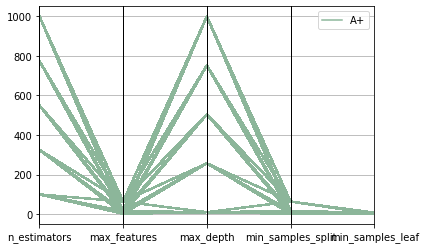

In [30]:
#Plotting the parallel coordinates
pd.plotting.parallel_coordinates(
    df, 'category', cols=['n_estimators', 'max_features', 'max_depth','min_samples_split','min_samples_leaf']
)

3. From the results of the above find the best estimators and use them for classifcation once again and evaluate the performance using 10 fold cross validation. (10 Points)

In [35]:
#Finding max accuracy
max_accuracy = max(df['accuracy'])
print(max_accuracy)

0.9944444444444445


In [56]:
#Finding estimators with best accuracies
dff = df.loc[df['accuracy']>=0.99]
dff

,n_estimators,max_features,max_depth,min_samples_split,min_samples_leaf,accuracy,precision,recall,f-1 score,category
155,100,4,257,4,1,0.991667,0.992046,0.991667,0.991704,A+
275,100,8,257,8,1,0.994444,0.994762,0.994444,0.994484,A+
900,325,8,257,8,1,0.991667,0.991894,0.991667,0.991519,A+


In [67]:
# Performing cross validation on these best performance. Accuracies of each fold coming out to be comparable.
for i in range(len(dff)):
    estimator_values = dff.iloc[i]
    clf = RandomForestClassifier(n_estimators=estimator_values['n_estimators'],
                                 max_features = estimator_values['max_features'],
                                 max_depth = estimator_values['max_depth'],
                                 min_samples_split = estimator_values['min_samples_split'],
                                 min_samples_leaf = estimator_values['min_samples_leaf'])
    score = cross_val_score(clf, X, Y, cv=10, scoring='accuracy')
    print('----------------------------------')
    print(clf)
    print(f'Accuracies for each fold are:{score}' )
    print(f'Average Accuracy:{score.mean()}' )
print('----------------------------------')

----------------------------------
RandomForestClassifier(max_depth=257, max_features=4, min_samples_split=4)
Accuracies for each fold are:[0.96666667 0.97222222 0.98888889 0.98888889 0.96111111 0.98333333
 0.96111111 0.95530726 0.97206704 0.97206704]
Average Accuracy:0.9721663563004345
----------------------------------
RandomForestClassifier(max_depth=257, max_features=8, min_samples_split=8)
Accuracies for each fold are:[0.97777778 0.97777778 0.98888889 0.99444444 0.97222222 0.97777778
 0.97222222 0.96089385 0.97206704 0.97206704]
Average Accuracy:0.9766139044072005
----------------------------------
RandomForestClassifier(max_depth=257, max_features=8, min_samples_split=8,
                       n_estimators=325)
Accuracies for each fold are:[0.96666667 0.97777778 0.98888889 0.98888889 0.97222222 0.97777778
 0.97777778 0.96089385 0.97765363 0.97206704]
Average Accuracy:0.9760614525139666
----------------------------------


4. Describe what is the difference between Randomized Search and Grid Search (4 points)


### Difference between Randomized Search and Grid Search
Both Grid Search and Randomized Search are used for hyperparameter tuning.
- Grid Search takes up the list of different values for different parameters and performs cross validation on models generated by all the combinations of parameters. Thus it can be seen as an exhaustive search. Suppose there are n parameters and each parameter can take m values, with k-folds, total $k(m^n)$ models are generated. Thus it takes more time to perform Grid Search than Randomized Search. Grid Search provides the optimal parameter selection as all combinations of parameters generate models in Grid Search.
- Randomized Search on the other hand takes up list or distribution function of different parameters and randomly selects combination of paramaters to generate models. The total number of different combinations of parameters to do would be specified during initialization of Randomized Search. Randomized Search is faster than Grid Search, but it is not guaranteed to give optimal parameter selection. Randomized Search gives the best parameter selection from the models it generates.

5. Why do we have to perform cross validation (3 points)


Small data size can result in an unreliable models if the training, testing split is biased. By reducing the training data, we risk losing important patterns/ trends in data set, which in turn increases error induced by bias. Cross validation is used to ensure that the model performance is stable and is not prone to outliers in the data. It makes sure that the model generated performs equally well with new unseen data.


6. Explain how each of the parameters of Random Forest considered effect the performance (5 points)

#### 1) n_estimators = Number of trees in random forest  
Increasing the number of trees increases the accuracy but at the same time increases the computation time. After a point, the increase is negligible as compared to increase in computational cost.
#### 2) max_features = Number of features to consider at every split
number of features to consider helps to decorrelate the base learners with reasonable predictive strengths. Higher values of max_features tend to perform better as it means more important features can be selected more often.
#### 3) max_depth = Maximum number of levels in tree 
Increasing the maximum number of levels increases the model complexity. Increasing complexity would result in increase in performance but at the same time increase in computational cost. 
#### 4) min_samples_split = Minimum number of samples required to split a node 
Increasing the minimum number of samples to split a node would reduce the model complexity. Lesser the number, more chance to overfit. Underfitting can happen if this number is very large.
#### 5) min_samples_leaf = Minimum number of samples required at each leaf node 
Simmilar to min_samples_split, increasing the minimum number of samples at each leaf would reduce the model complexity. Lesser the number, more chance to overfit. Underfitting can happen if this number is very large.